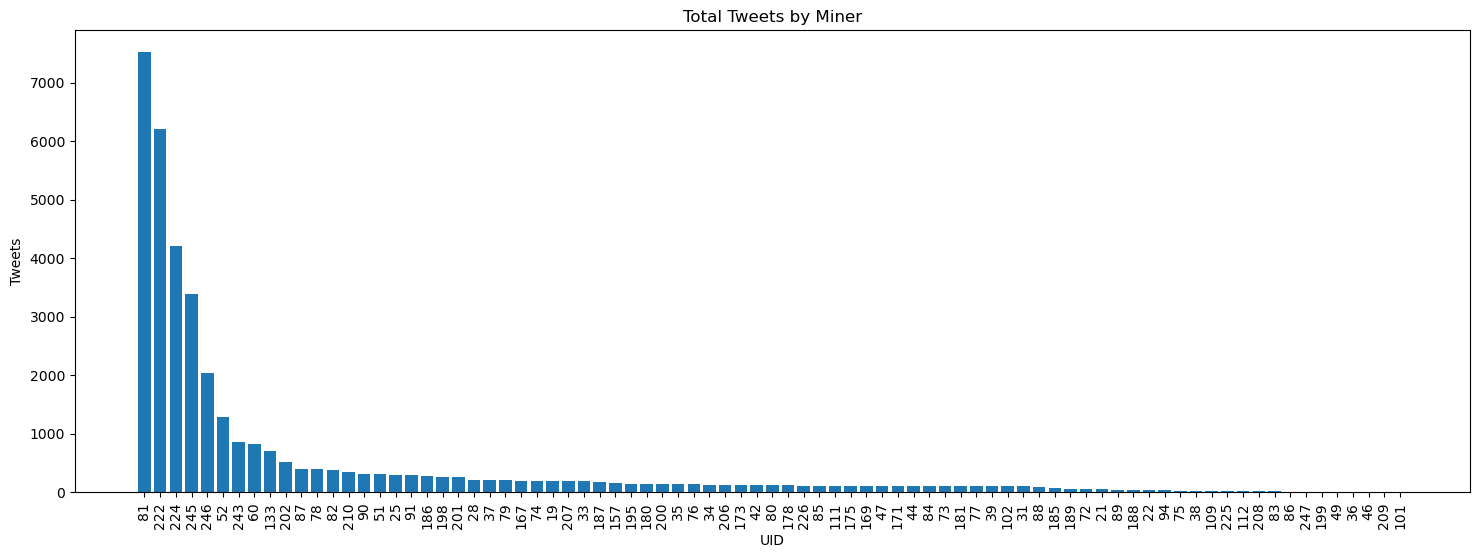

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import json

volumes = json.load(open("volumes.json"))

# Calculate the sum of volumes for each miner
volumes_df = {}
for data in volumes:
    for miner, volume in data["miners"].items():
        if volume > 0:  # Only consider miners with volume greater than 0
            if miner in volumes_df:
                volumes_df[miner] += volume
            else:
                volumes_df[miner] = volume

# Convert to DataFrame for easier plotting
df = pd.DataFrame(list(volumes_df.items()), columns=['UID', 'Volume'])

# Sort the DataFrame by total volume
df = df.sort_values(by='Volume', ascending=False)

# Plot the volumes
plt.figure(figsize=(18, 6))
plt.bar(df['UID'], df['Volume'])
plt.xlabel('UID')
plt.ylabel('Tweets')
plt.title('Total Tweets by Miner')
plt.xticks(rotation=90)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f017507a-86ad-40cb-8efa-5587c78ee158' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>